## 0. Goal 
Calculate spectrograms from segmented datasets. <br>
Use the function from Goffinet...Pearson <br>
Differ from v2: fixed parameters, but set shortest duration cutoff to remove very short syllables

In [1]:
import os, sys, importlib, librosa, glob, h5py, tqdm
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
import random
import umap, hdbscan
from collections import Counter
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch
from matplotlib.colors import ListedColormap

plt.rcParams['pdf.fonttype'] = 42 

In [17]:
# import my utility script
cluster_script_path = '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/'
sys.path.insert(1, cluster_script_path)
import vae_goffinet, hopkins
importlib.reload(vae_goffinet)

<module 'vae_goffinet' from '/home/zz367/ProjectsU/EphysMONAO/Jupyter/MatlabCodes/ZZ_callClustering/vae_goffinet.py'>

In [3]:
# create a custom colormap for spectrogram
jet = plt.get_cmap('jet', 255)
# Extract jet colors and prepend black at the beginning
jet_colors = jet(np.linspace(0, 1, 255))
custom_colors = np.vstack([[0, 0, 0, 1], jet_colors])  # Black for 0, then jet
custom_cmap = ListedColormap(custom_colors)

## 1. Inputs

In [12]:
fd_z4 = '/mnt/z4'
fd_data = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav')
birdIDs = ['pair5RigCCU29', 'pair4RigACU68', 'pair4RigBCU53', 'pair2RigBCU25']
# color limits when calculating spectrograms, depending on the audio amplitude, may differ between birds
clims = [[1.5,7], [1.5,7], [1.5,8.5], [1.5,8.5]]
# what syllable to analyze
syl = ['v']
# remove calls with very short duration
dur_cutoff = 0.05   # unit is sec

In [5]:
# define parameters for spectrograms
X_SHAPE = [128, 128]
p = {
    'get_spec': vae_goffinet.get_specZZ, # spectrogram maker
    'max_dur': 1e9, # maximum syllable duration
    'min_freq': 250, # minimum frequency
    'max_freq': 7500, # maximum frequency, default 7500
    'num_freq_bins': X_SHAPE[0], # hard-coded
    'num_time_bins': X_SHAPE[1], # hard-coded
    'nperseg': 256, # FFT
    'noverlap': 176, # FFT, determines window overlap when calculating spectrograms
    'spec_min_val': 1.5, # minimum log-spectrogram value
    'spec_max_val': 7, # maximum log-spectrogram value
    'fs': 20000, # audio samplerate
    'mel': False, # frequency spacing, mel or linear
    'time_stretch': False, # stretch short syllables?
    'within_syll_normalize': False, # normalize spectrogram values on a # spectrogram-by-spectrogram basis
    'max_num_syllables': None, # maximum number of syllables per directory
    'sylls_per_file': 20, # syllable per file, not used
    'real_preprocess_params': ('min_freq', 'max_freq', 'spec_min_val', 'spec_max_val'), # tunable parameters
    'int_preprocess_params': ('nperseg','noverlap'), # tunable parameters
    'binary_preprocess_params': ('time_stretch', 'mel', 'within_syll_normalize'), # tunable parameters
    'window_length': 0.032,  # for continuous sliding: size of the spectrogram window, unit is sec
    'hop_length': 0.004  # for continuous sliding: how much to hop for successive spectrogram windows, unit is sec
}

## 2. Loop through birds, calculate spectrograms

Processing for pair4RigACU68...
Spectrogram window size (ms): 12.800
Spectrogram window hop (ms): 4.000
spec_goffinet_cutoff_256_176
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigACU68/Spectrogram4/v/pair4RigACU68.v.spec_goffinet_cutoff_256_176.h5
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigACU68/Spectrogram4/v/pair4RigACU68.v.spec_goffinet_cutoff_256_176.info.csv
Total number of wav files: 4100
Calculating max duration...


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done   1 out of   1 | elapsed:    4.9s finished
[Parallel(n_jobs=48)]: Done  67 tasks      | elapsed:    6.5s
[Parallel(n_jobs=48)]: Done 193 tasks      | elapsed:    7.3s
[Parallel(n_jobs=48)]: Done 355 tasks      | elapsed:    7.8s
[Parallel(n_jobs=48)]: Done 553 tasks      | elapsed:    8.6s
[Parallel(n_jobs=48)]: Done 787 tasks      | elapsed:    9.3s
[Parallel(n_jobs=48)]: Done 1057 tasks      | elapsed:   10.3s
[Parallel(n_jobs=48)]: Done 1363 tasks      | elapsed:   11.3s
[Parallel(n_jobs=48)]: Done 1705 tasks      | elapsed:   12.5s
[Parallel(n_jobs=48)]: Done 2083 tasks      | elapsed:   13.7s
[Parallel(n_jobs=48)]: Done 2497 tasks      | elapsed:   15.1s
[Parallel(n_jobs=48)]: Done 2947 tasks      | elapsed:   16.6s
[Parallel(n_jobs=48)]: Done 3433 tasks      | elapsed:   18.2s
[Parallel(n_jobs=48)]: Done 3955 tasks      | elapsed:   19.9s
[Parallel(n_jobs=48)]: Done 4100 out o

Total number of syllables: 36359
0.99 quantile: 0.3050
No. of short calls removed: 63
Calculating spectrograms...


[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:    0.5s
[Parallel(n_jobs=48)]: Done 288 tasks      | elapsed:    2.0s
[Parallel(n_jobs=48)]: Done 612 tasks      | elapsed:    4.4s
[Parallel(n_jobs=48)]: Done 1008 tasks      | elapsed:    6.9s
[Parallel(n_jobs=48)]: Done 1476 tasks      | elapsed:    9.9s
[Parallel(n_jobs=48)]: Done 2016 tasks      | elapsed:   13.1s
[Parallel(n_jobs=48)]: Done 2628 tasks      | elapsed:   16.8s
[Parallel(n_jobs=48)]: Done 3312 tasks      | elapsed:   21.0s
[Parallel(n_jobs=48)]: Done 4005 out of 4100 | elapsed:   25.3s remaining:    0.6s
[Parallel(n_jobs=48)]: Done 4100 out of 4100 | elapsed:   25.7s finished


36296 (36296, 7)


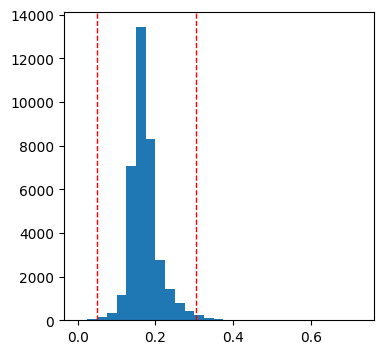

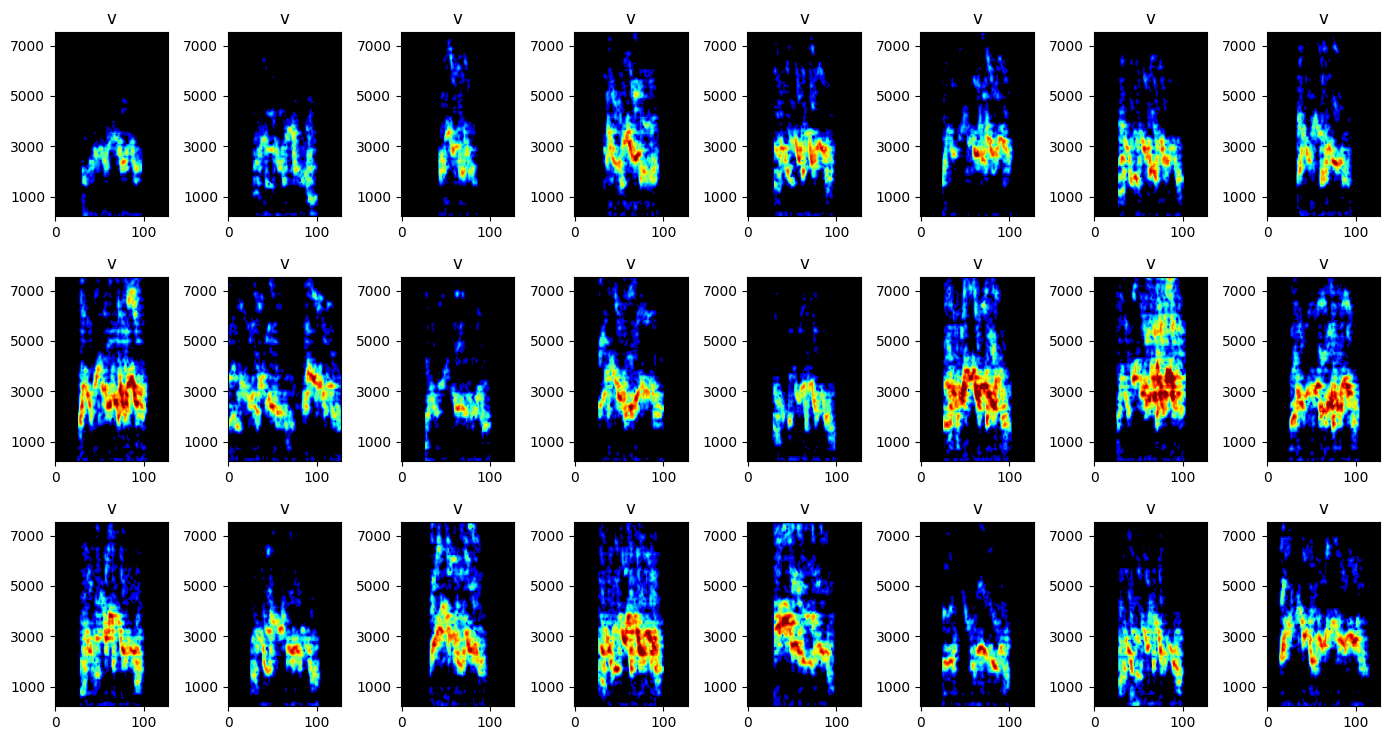

max pixel value: 1.0
(36296, 128, 128)
Processing for pair4RigBCU53...
Spectrogram window size (ms): 12.800
Spectrogram window hop (ms): 4.000
spec_goffinet_cutoff_256_176
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigBCU53/Spectrogram4/v/pair4RigBCU53.v.spec_goffinet_cutoff_256_176.h5
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair4RigBCU53/Spectrogram4/v/pair4RigBCU53.v.spec_goffinet_cutoff_256_176.info.csv
Total number of wav files: 2645
Calculating max duration...


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:    0.2s
[Parallel(n_jobs=48)]: Done 288 tasks      | elapsed:    0.9s
[Parallel(n_jobs=48)]: Done 612 tasks      | elapsed:    2.0s
[Parallel(n_jobs=48)]: Done 1008 tasks      | elapsed:    3.4s
[Parallel(n_jobs=48)]: Done 1476 tasks      | elapsed:    5.0s
[Parallel(n_jobs=48)]: Done 2016 tasks      | elapsed:    6.8s
[Parallel(n_jobs=48)]: Done 2528 out of 2623 | elapsed:    8.4s remaining:    0.3s
[Parallel(n_jobs=48)]: Done 2623 out of 2623 | elapsed:    8.6s finished


Total number of syllables: 16194
0.99 quantile: 0.3030
No. of short calls removed: 35
Calculating spectrograms...


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:    0.6s
[Parallel(n_jobs=48)]: Done 288 tasks      | elapsed:    1.9s
[Parallel(n_jobs=48)]: Done 612 tasks      | elapsed:    3.9s
[Parallel(n_jobs=48)]: Done 1008 tasks      | elapsed:    6.2s
[Parallel(n_jobs=48)]: Done 1476 tasks      | elapsed:    9.0s
[Parallel(n_jobs=48)]: Done 2016 tasks      | elapsed:   12.1s
[Parallel(n_jobs=48)]: Done 2550 out of 2645 | elapsed:   15.0s remaining:    0.6s
[Parallel(n_jobs=48)]: Done 2645 out of 2645 | elapsed:   15.4s finished


16159 (16159, 7)


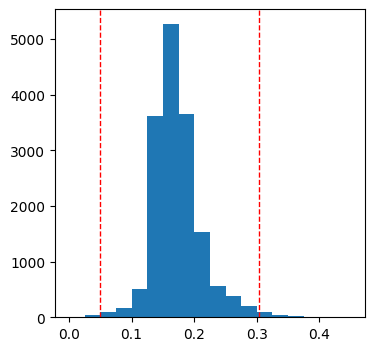

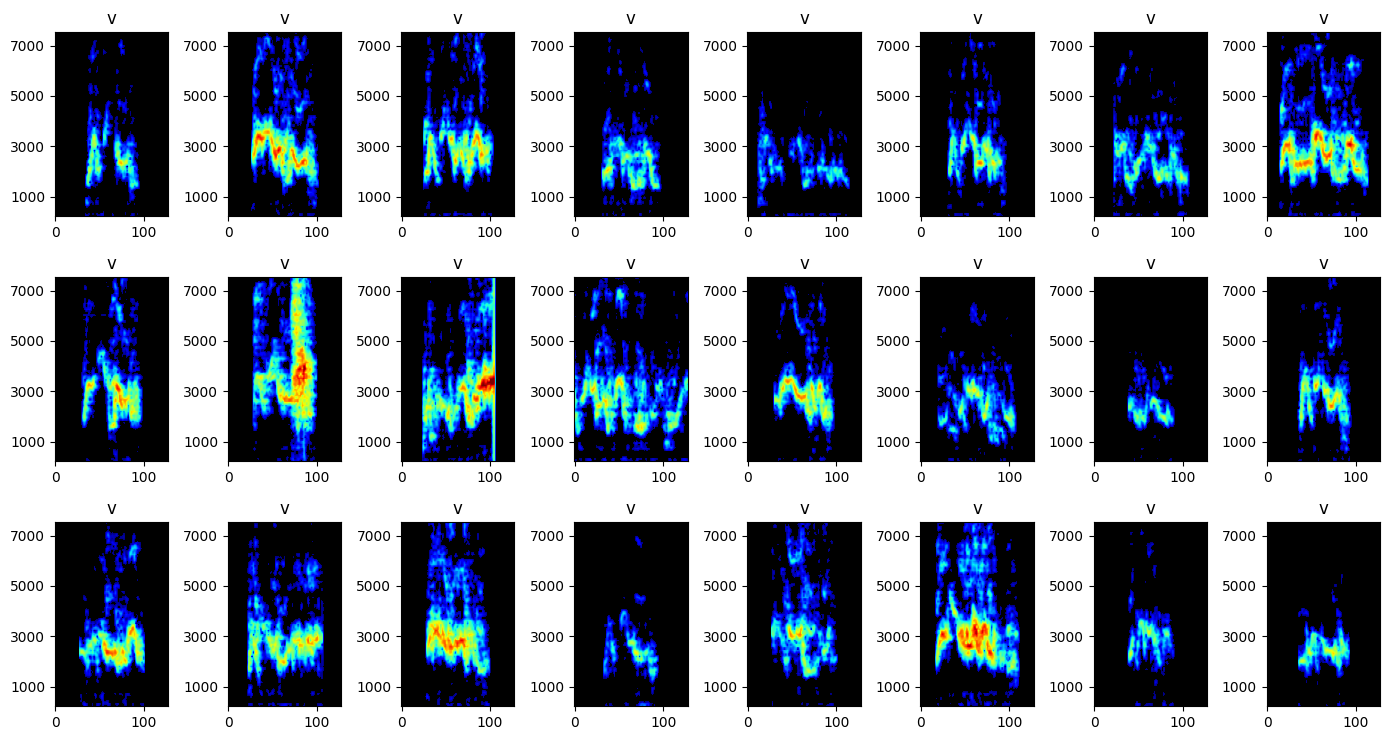

max pixel value: 1.0
(16159, 128, 128)
Processing for pair2RigBCU25...
Spectrogram window size (ms): 12.800
Spectrogram window hop (ms): 4.000
spec_goffinet_cutoff_256_176
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/Spectrogram4/v/pair2RigBCU25.v.spec_goffinet_cutoff_256_176.h5
/mnt/z4/zz367/EphysMONAO/Analyzed/vaeWav/pair2RigBCU25/Spectrogram4/v/pair2RigBCU25.v.spec_goffinet_cutoff_256_176.info.csv
Total number of wav files: 2600
Calculating max duration...


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:    0.2s
[Parallel(n_jobs=48)]: Done 288 tasks      | elapsed:    0.9s
[Parallel(n_jobs=48)]: Done 612 tasks      | elapsed:    2.0s
[Parallel(n_jobs=48)]: Done 1008 tasks      | elapsed:    3.2s
[Parallel(n_jobs=48)]: Done 1476 tasks      | elapsed:    4.7s
[Parallel(n_jobs=48)]: Done 2016 tasks      | elapsed:    6.4s
[Parallel(n_jobs=48)]: Done 2366 out of 2461 | elapsed:    7.5s remaining:    0.3s
[Parallel(n_jobs=48)]: Done 2461 out of 2461 | elapsed:    7.6s finished


Total number of syllables: 16452
0.99 quantile: 0.3020
No. of short calls removed: 42
Calculating spectrograms...


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  66 tasks      | elapsed:    0.5s
[Parallel(n_jobs=48)]: Done 288 tasks      | elapsed:    1.9s
[Parallel(n_jobs=48)]: Done 612 tasks      | elapsed:    3.7s
[Parallel(n_jobs=48)]: Done 1008 tasks      | elapsed:    5.9s
[Parallel(n_jobs=48)]: Done 1476 tasks      | elapsed:    8.3s
[Parallel(n_jobs=48)]: Done 2016 tasks      | elapsed:   11.1s
[Parallel(n_jobs=48)]: Done 2600 out of 2600 | elapsed:   14.0s finished


16410 (16410, 7)


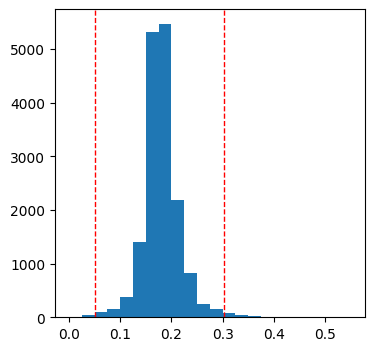

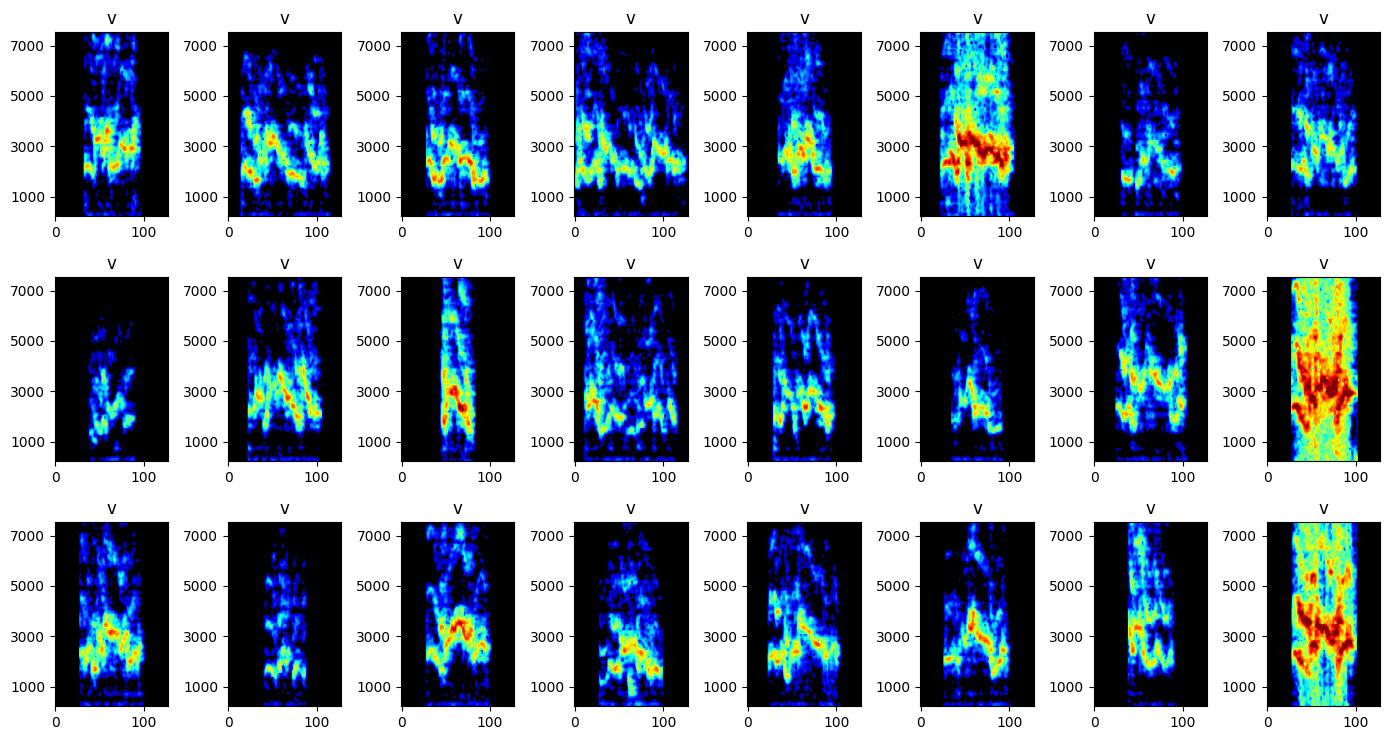

max pixel value: 1.0
(16410, 128, 128)


In [22]:
for bi in range(1,len(birdIDs)):
# for bi in range(1):
    bd = birdIDs[bi]
    print(f'Processing for {bd}...')
    # change the color limit
    p['spec_min_val'] = clims[bi][0]
    p['spec_max_val'] = clims[bi][1]
    
    # print the spectrogram win and hop length
    win_ms = p['nperseg']/p['fs']*1000
    hop_ms = (p['nperseg']-p['noverlap'])/p['fs']*1000
    print(f'Spectrogram window size (ms): {win_ms:.3f}')
    print(f'Spectrogram window hop (ms): {hop_ms:.3f}')
    
    ## given the current run a name
    run_name = f'spec_goffinet_cutoff_256_176'
    print(run_name)
    
    # save to specific folder
    temp = ''.join(syl)
    fd_save = os.path.join(fd_z4, 'zz367', 'EphysMONAO', 'Analyzed', 'vaeWav', bd, 'Spectrogram4', temp)
    if not os.path.exists(fd_save):
        os.makedirs(fd_save)
    fn_h5 = os.path.join(fd_save, f'{bd}.{temp}.{run_name}.h5')
    fn_info = os.path.join(fd_save, f'{bd}.{temp}.{run_name}.info.csv')
    print(fn_h5)
    print(fn_info)

    ## grab all wav files
    fns_wav = sorted(glob.glob(os.path.join(fd_data, bd, 'Audio', '*', '*.wav')))
    fns_label = sorted(glob.glob(os.path.join(fd_data, bd, 'Audio', '*', '*.label.txt')))
    print(f'Total number of wav files: {len(fns_wav)}')

    ## loop through files determine the max syllable duration
    print('Calculating max duration...')
    with Parallel(n_jobs=48, verbose=5) as parallel:
        dur_all = parallel(delayed(vae_goffinet.ZZ_getDur_v1)(fn, fs=p['fs'], syl=syl) for fn in fns_label)

    dur_flat = [item for sublist in dur_all for item in sublist]

    q = 0.99
    max_dur = np.quantile(dur_flat, q)
    print(f'Total number of syllables: {len(dur_flat)}')
    print(f'{q} quantile: {max_dur:.4f}')
    # plot duration distribution
    fig, ax = plt.subplots(figsize=(4,4))
    bin_width = 0.025
    bins = np.arange(0, np.amax(dur_flat) + bin_width, bin_width)
    ax.hist(dur_flat, bins=bins)
    ax.axvline(x=max_dur, color='r', linestyle='--', linewidth=1)
    ax.axvline(x=dur_cutoff, color='r', linestyle='--', linewidth=1)

    # how many calls have shorter duration 
    num_rm = len([aa for aa in dur_flat if aa<dur_cutoff])
    print(f'No. of short calls removed: {num_rm}')

    ## calculate spectrogram
    print('Calculating spectrograms...')
    with Parallel(n_jobs=48, verbose=5) as parallel:
        res = parallel(delayed(vae_goffinet.ZZ_specFromWavGoffinet_v2)(fn, p, syl, max_dur, dur_cutoff) for fn in fns_wav)

    # flatten the result
    temp = [aa[0] for aa in res]
    specs = [arr for sublist in temp if sublist for arr in sublist]
    df_list = [aa[1] for aa in res]
    info = pd.concat([df for df in df_list if not df.empty], ignore_index=True)
    print(len(specs), info.shape)

    # plot some example spectrograms to check 
    nrow = 3
    ncol = 8
    random.seed(1118)
    idx_rd = random.sample(range(len(specs)), nrow*ncol)
    fig, axes = plt.subplots(nrow, ncol, figsize=(14, nrow*2.5))
    for ii in range(len(idx_rd)):
        plot_i = ii//ncol
        plot_j = ii%ncol
        ax = axes[plot_i][plot_j]
        ax.imshow(specs[idx_rd[ii]], aspect='auto', cmap=custom_cmap, vmin=0, vmax=1, origin='lower')
        ax.set_title(info.loc[idx_rd[ii], 'label'])
        # set y tick labels
        query_freqs = [1000, 3000, 5000, 7000]
        target_freqs = info.loc[idx_rd[ii], 'spec_f']
        indices = np.arange(len(target_freqs))
        # Interpolate: given a value, find where it lies in the index space
        interp_indices = np.interp(query_freqs, target_freqs, indices)
        ax.set_yticks(interp_indices)
        ax.set_yticklabels(query_freqs)
    plt.tight_layout()
    plt.show()
    # save figure
    temp = ''.join(syl)
    fn_fig = os.path.join(fd_save, f'{bd}.{temp}.{run_name}.pdf')
    fig.savefig(fn_fig)
    print('max pixel value:', np.amax(specs))

    ## save results
    # save padded spectrograms as h5 file 
    spec_win_all = np.stack(specs, axis=0)
    print(spec_win_all.shape)
    with h5py.File(fn_h5, 'w') as f:
        f.create_dataset('spec_win_all', data=spec_win_all)

    # save meta info as well
    info.to_csv(fn_info)